In [1]:
import math
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

In [2]:
# We will set a seed to ensure repeatability of training
torch.manual_seed(42)

In [3]:
# Load the dataset
mnist_transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])
train_data = datasets.MNIST(
    root = 'datasets',
    train = True,                         
    transform = mnist_transforms, 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'datasets',
    train = False,                         
    transform = mnist_transforms, 
    download = True, 
)

In [4]:
# Let us take a look at the train and test data
# Each image is of shape 28 * 28 and we have 60000 train examples
assert train_data.data.shape == torch.Size((60000, 28, 28))
print(f"Train data size {train_data.data.shape}")  # We have 60000 images of shape 28x28
assert train_data.targets.shape == torch.Size([60000])# We have a target for each image
print(f"Train data target {train_data.targets.shape}")

print(f"Test data size {test_data.data.shape}") # We have 10000 images for test
print(f"Test data target {test_data.targets.shape}")


Train data size torch.Size([60000, 28, 28])
Train data target torch.Size([60000])
Test data size torch.Size([10000, 28, 28])
Test data target torch.Size([10000])


In [5]:
def plot_data(X, y, prefix, num_to_plot=24):
    # Let us sample a few random images to plot
    assert X.shape[0] == y.shape[0]
    sample_idx = torch.randint(len(X), size=(num_to_plot,))
    # We will plot the images in a grid
    figure = plt.figure(figsize=(10, 8))
    num_cols = 3
    num_rows = int(math.ceil(num_to_plot/ num_cols))
    for i in range(num_to_plot):
        img =  X[sample_idx[i]]
        label = y[sample_idx[i]]
        figure.add_subplot(num_rows, num_cols, i+1)
        plt.title(f"{prefix}_{label}") 
        plt.axis("off")
        plt.tight_layout()
        plt.imshow(img.squeeze(), cmap="gray")
        
    plt.show()

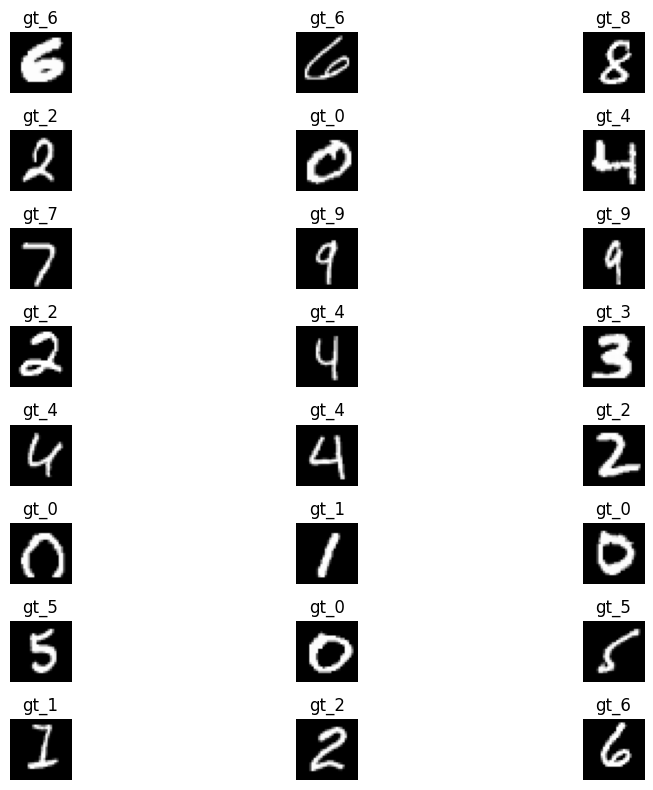

In [6]:
plot_data(train_data.data, train_data.targets, "gt")

In [7]:
# Let us define the neural network architecture
class LeNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Sequential(
                        torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
                        torch.nn.Tanh(),
                        torch.nn.AvgPool2d(kernel_size=2))
        self.conv2 = torch.nn.Sequential(
                        torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
                        torch.nn.Tanh(),
                        torch.nn.AvgPool2d(kernel_size=2))
        self.conv3 = torch.nn.Sequential(
                        torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
                        torch.nn.Tanh())
        self.fc1 = torch.nn.Sequential(
                        torch.nn.Linear(in_features=120, out_features=84),
                        torch.nn.Tanh())
        self.fc2 = torch.nn.Linear(in_features=84, out_features=num_classes)
        
    def forward(self, X):
        conv_out = self.conv3(self.conv2(self.conv1(X)))
        batch_size = conv_out.shape[0]
        conv_out = conv_out.reshape(batch_size, -1)
        logits = self.fc2(self.fc1(conv_out))
        return logits    
    
    def predict(self, X):
        logits = self.forward(X)
        probs = torch.softmax(logits, dim=1)
        return torch.argmax(probs, 1)

In [8]:
# Let us create dataloaders for the datasets
batch_size=100
train_dataloader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0)
    
test_dataloader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0)

In [9]:
def compute_accuracy(gt, logits):
    assert gt.shape[0] == logits.shape[0] # Same batch size
    with torch.no_grad():
        probs = torch.softmax(logits, 1)
        predicted_labels = torch.argmax(probs, 1)
        correct_pred = (predicted_labels == gt).to(torch.int).sum()
        accuracy = correct_pred / len(gt)
    return accuracy
    
def train(model, data_loader, criterion, optimizer, device, epoch):
    # Set training mode
    model.train()
    for i, (X, y_true) in enumerate(data_loader):
        optimizer.zero_grad()
        X = X.to(device)
        y_true = y_true.to(device)
        
        y_pred_logits = model.forward(X)
        loss = criterion(y_pred_logits, y_true)
        if i % 100 == 0:
            accuracy = compute_accuracy(y_true, y_pred_logits)
            print(f"Epoch {epoch}, Step {i}: Training loss: {loss} Accuracy: {accuracy}")
        loss.backward()
        optimizer.step()
        
def test(model, data_loader, criterion, device):
    model.eval()
    batch_loss, batch_acc = [], []
    for i, (X, y_true) in enumerate(data_loader):
        X = X.to(device)
        y_true = y_true.to(device)
        
        y_pred_logits = model.forward(X)
        batch_loss.append(criterion(y_pred_logits, y_true))
        batch_acc.append(compute_accuracy(y_true, y_pred_logits))
    avg_loss = sum(batch_loss) / len(batch_loss)
    avg_acc = sum(batch_acc) / len(batch_acc)
    return {"loss": avg_loss, "accuracy": avg_acc}

In [10]:
# Train test loop
num_classes = 10

# To determine the device. If torch.cuda is available, we use the GPU else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = LeNet(num_classes).to(device)
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9)
# Criterion
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    train(model, train_dataloader, criterion, optimizer, device, epoch)
    with torch.no_grad():
        test_results = test(model, test_dataloader, criterion, device)
        print(f"Epoch {epoch}, Test loss: {test_results['loss']} Accuracy: {test_results['accuracy']}")
        
# Saving the best model
# We save the entire state dictionary here. If you want to save only the model weights,
# then you can just save model.state_dict()
save_path = "/tmp/lenet_mnist.pkl"
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_results': test_results,
            }, save_path)

Epoch 0, Step 0: Training loss: 2.3075952529907227 Accuracy: 0.09000000357627869
Epoch 0, Step 100: Training loss: 1.1151868104934692 Accuracy: 0.7099999785423279
Epoch 0, Step 200: Training loss: 0.41789761185646057 Accuracy: 0.8299999833106995
Epoch 0, Step 300: Training loss: 0.33552873134613037 Accuracy: 0.8700000047683716
Epoch 0, Step 400: Training loss: 0.23367002606391907 Accuracy: 0.9300000071525574
Epoch 0, Step 500: Training loss: 0.2527003884315491 Accuracy: 0.9399999976158142
Epoch 0, Test loss: 0.21143069863319397 Accuracy: 0.9375999569892883
Epoch 1, Step 0: Training loss: 0.15388882160186768 Accuracy: 0.949999988079071
Epoch 1, Step 100: Training loss: 0.24883875250816345 Accuracy: 0.9100000262260437
Epoch 1, Step 200: Training loss: 0.08255451917648315 Accuracy: 0.9900000095367432
Epoch 1, Step 300: Training loss: 0.15075550973415375 Accuracy: 0.949999988079071
Epoch 1, Step 400: Training loss: 0.13896365463733673 Accuracy: 0.9399999976158142
Epoch 1, Step 500: Trainin

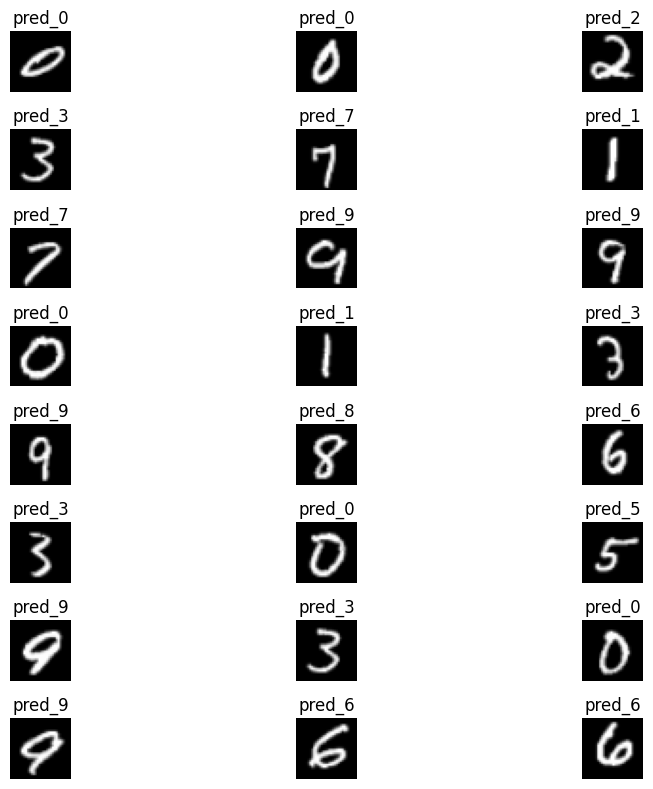

In [11]:
# Let us visualize some results
model.eval()
X, y_true = next(iter(test_dataloader))
with torch.no_grad():
    y_pred = model.predict(X)

plot_data(X, y_pred, "pred", num_to_plot=24)

In [12]:
def visualize_filters(weights, title):
    n,c,w,h = weights.shape
    weights = weights.view(n*c, -1, w, h)
    nrow = 10
    rows = min(weights.shape[0] // nrow + 1, 64)   
    grid = utils.make_grid(weights, nrow=nrow, normalize=True, padding=1)
    plt.figure(figsize=(nrow, rows))
    plt.title(title)
    plt.axis('off')
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
def plot_conv_filters(model):
    # Get all the conv filters
    conv_filters = [module for module in model.modules() if isinstance(module, torch.nn.Conv2d)]
    for i, conv in enumerate(conv_filters):
        visualize_filters(conv.weight.detach(), f"conv_{i}")

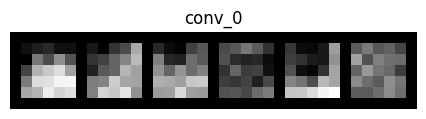

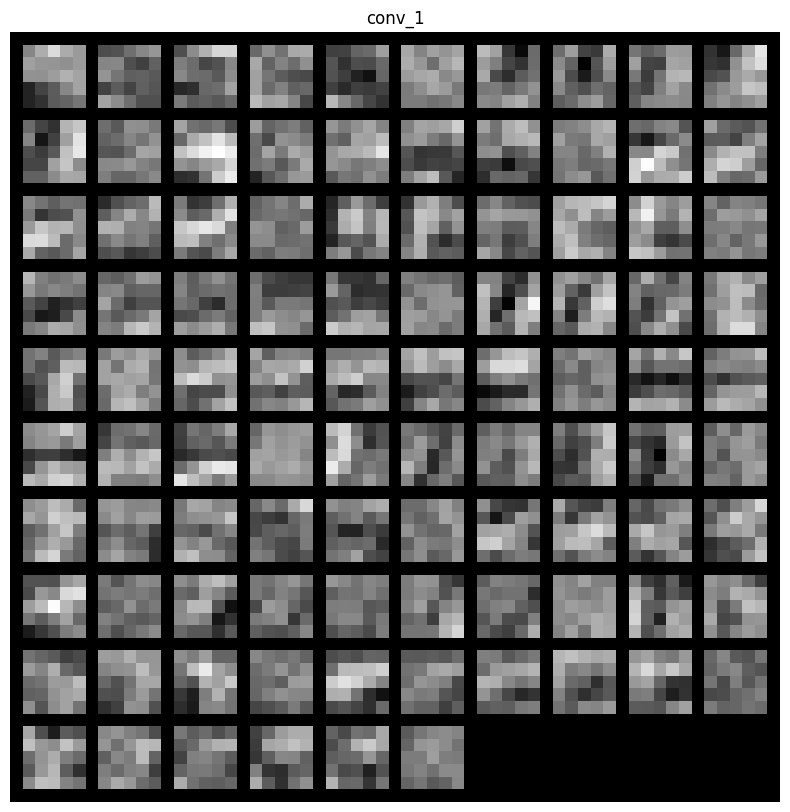

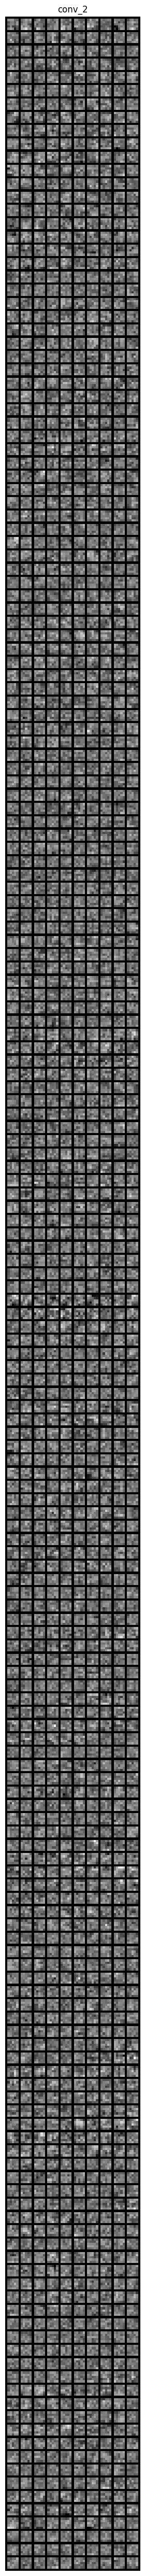

In [13]:
plot_conv_filters(model)